In the context of statistics and in particular machine learning, regularization is the name given to a process aimed primarily at reducing problems related to overfitting. And this, through a reduction of the variance or a selection of the number of parameters used. This process is not neutral since it consists of introducing new information to the problem, with the aim of "simplifying" it, either by introducing a penalty that increases as the complexity of the model increases or by "imposing" a prior distribution of the parameters of the model.

The general principle of regularization is to penalize extreme values ​​of parameters (which often leads to the overfitting variance). We then seek to minimize both the model with respect to our metric of choice as well as a metric on the size and the number of parameters used.

we will be focused on a family of regularization tools related to linear models, namely: ridge, lasso and elastic net. But there are obviously other tools suitable for other issues, we are thinking in particular of AIC/BIC (Akaike information criterion/Bayesian information criterion), PCR (Principal component regression), PLS (Partial least squares), LARS (Least- regression angle) and so on.

**BREAST CANCER DATASET - REGRESSION WITH FOCUS ON RIDGE LASSO AND ELASTIC NET METHODS**

In [65]:
#Importing libraries 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#import hvplot.pandas
%matplotlib inline

sns.set_style("whitegrid")
plt.style.use("fivethirtyeight")

In [66]:
#Convert exel file to csv
pcaData = pd.read_excel('regDataPca.xlsx')
pcaData.to_csv('regDataPca.csv', index=False)

In [67]:
#reading datafile already preprocessed

pcaData=pd.read_csv('regDataPca.csv')
pcaData.head()

,id number,PC1,PC2,PC3,PC4,Time
0,119513,48.324627,-21.799122,-1.410918,8.694068,31
1,8423,552.886776,280.325301,47.500418,-15.450619,61
2,842517,672.695079,-78.562915,-24.215818,-12.187407,116
3,843483,-1019.264328,89.162527,13.259976,-3.465499,123
4,843584,312.000254,-198.821628,10.992843,-14.668684,27


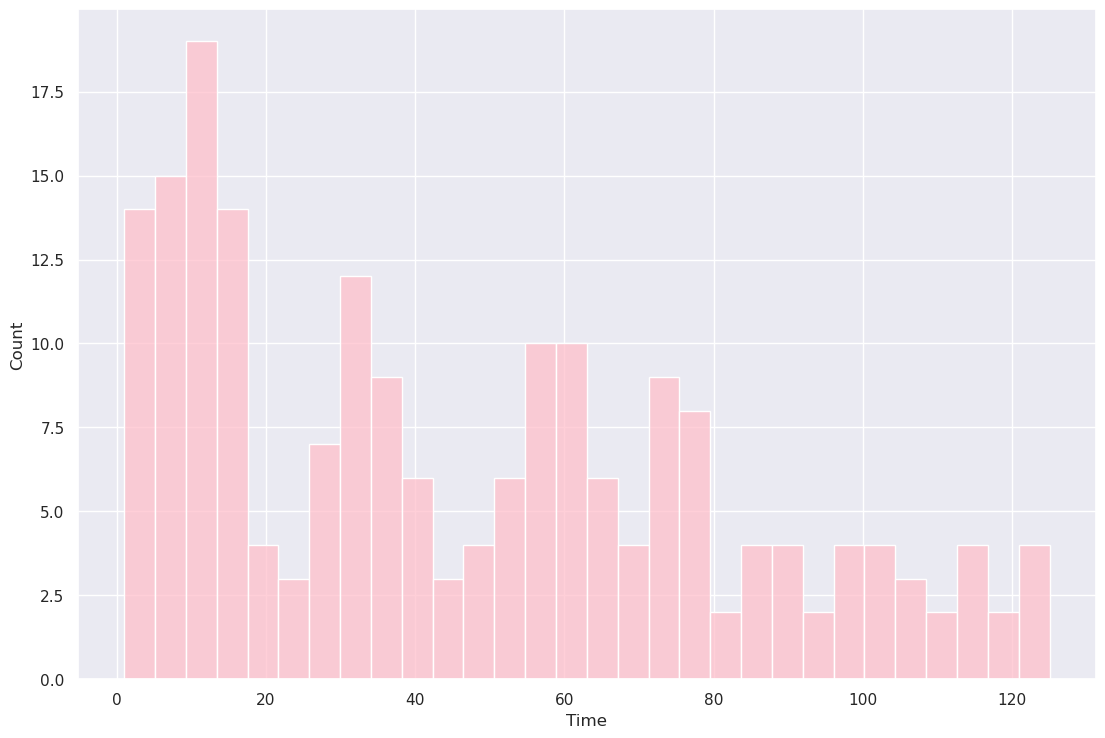

In [68]:
# set the size of the figure
sns.set(rc={'figure.figsize':(11.7,8.27)})
# plot a histogram showing the distribution of the target values
sns.histplot(pcaData['Time'], bins=30, color='pink')
plt.show()

<AxesSubplot:>

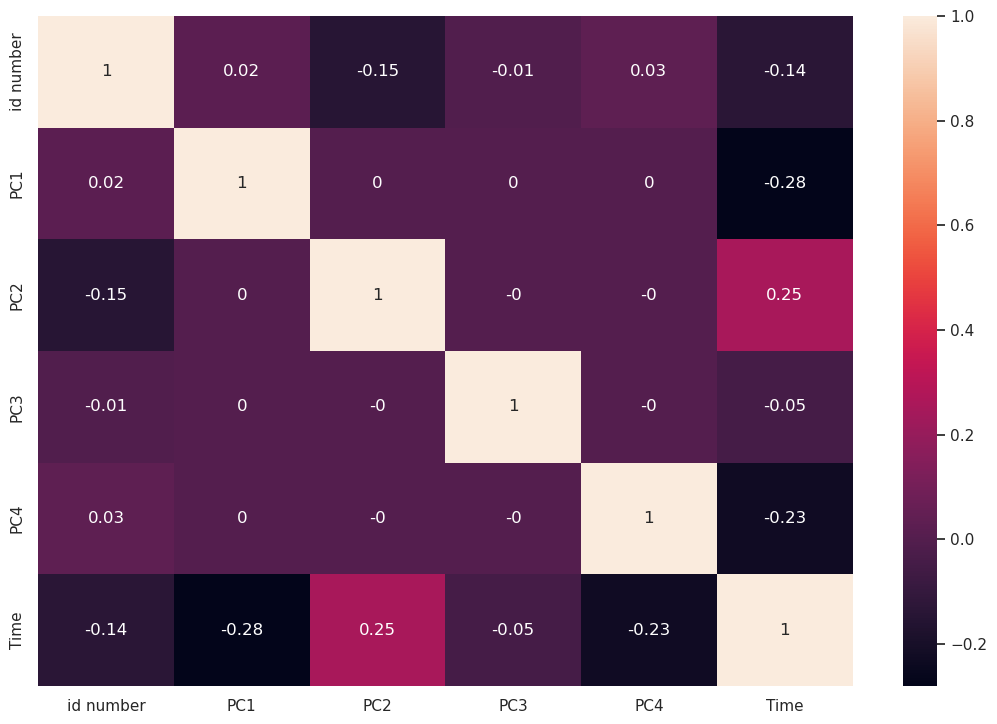

In [69]:
# compute the pair wise correlation for all columns
correlation_matrix = pcaData.corr().round(2)
# use the heatmap function from seaborn to plot the correlation matrix
# annot = True to print the values inside the square
sns.heatmap(data=correlation_matrix, annot=True)

In [70]:
#define target and features
target = pcaData['Time'].values
features = pcaData.drop(['Time'], axis = 1)
#rename target and features
X = features
y = target

In [71]:
print(y.shape)
print(X.shape)
print(pcaData.shape)

(198,)
(198, 5)
(198, 6)


In [72]:
#splitting data into train and test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape , X_test.shape

((158, 5), (40, 5))

## Regression Evaluation Metrics loss functions


Here are three common evaluation metrics for regression problems:

- **Mean Absolute Error** is the easiest to understand, because it's the average error. (MAE) is the mean of the absolute value of the errors:
$$\frac 1n\sum_{i=1}^n|y_i-\hat{y}_i|$$

 - **Mean Squared Error**  is more popular than MAE, because MSE "punishes" larger errors, which tends to be useful in the real world.
 (MSE) is the mean of the squared errors:
$$\frac 1n\sum_{i=1}^n(y_i-\hat{y}_i)^2$$

- **Root Mean Squared Error** is even more popular than MSE, because RMSE is interpretable in the "y" units. (RMSE) is the square root of the mean of the squared errors:
$$\sqrt{\frac 1n\sum_{i=1}^n(y_i-\hat{y}_i)^2}$$


In [73]:
#upload libraries for evaluation matrices calculation
from sklearn import metrics
from sklearn.model_selection import cross_val_score

In [74]:
#scaling data is important for linear regression so we use StandardScaler

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

pipeline = Pipeline([
    ('std_scalar', StandardScaler())
])

X_Train = pipeline.fit_transform(X_train)
X_Test = pipeline.transform(X_test)

X_Train

array([[ 2.51474134e+00, -1.64066699e+00,  8.43030357e-01,
         1.32780404e-01,  2.72069200e-02],
       [-3.84489188e-01, -1.22653102e+00,  7.49833744e-01,
         2.22722179e-01, -1.66219369e+00],
       [-3.75296521e-01, -1.47287135e+00,  6.66815249e-01,
         3.17520826e-01, -9.04979810e-01],
       [-6.51874965e-01, -1.06756275e+00, -4.12966133e-01,
         1.59066465e-01,  2.86266711e-01],
       [-3.69348700e-01, -1.02417127e+00,  3.84124228e-01,
         1.58182560e-01, -1.36090565e+00],
       [-3.55164208e-01,  1.28182226e+00, -1.07035644e+00,
         1.61700989e+00, -2.33742353e-01],
       [-3.70906894e-01,  9.41860358e-01, -5.26993633e-01,
        -1.11872136e+00,  1.30488522e+00],
       [-3.68301506e-01, -6.85567552e-01, -1.12819027e-01,
        -7.26112337e-01, -2.05129446e-01],
       [-3.83568324e-01, -8.16241563e-01, -8.08803338e-01,
        -1.80631860e-03, -1.14890247e-01],
       [-3.80117304e-01, -9.59591075e-01,  1.20209679e+00,
        -1.46739452e-01

**Cros Validation** is a statistical method of evaluating and comparing learning algorithms by dividing data into two segments: one used to learn or train a model and the other used to validate the model. In typical cross-validation, the training and validation sets must cross-over in successive rounds such that each data point has a chance of being validated against. 

**More about this in report**


In [75]:
#Defining function to do cross validation for each model

def cross_val(model):
    pred = cross_val_score(model, X, y, cv=10)
    return pred.mean()

In [76]:
#define function to calculate optimal alpha value
def optimal_alpha(model):
    alpha = []
    error = []

    for i in range(1,100):
        alpha.append(i/100)
        model.set_params(alpha=i/100)
        model.fit(X_Train, y_train)
        pred_i = model.predict(X_Test)
        error.append(metrics.mean_squared_error(y_test, pred_i))

    return pd.DataFrame(list(zip(alpha, error)), columns=['alpha', 'error']).sort_values(by='error').head(1)



In [77]:
#define function to calcuate evaluation matrices for each model 

    
def evaluate(true, predicted):
    mae = metrics.mean_absolute_error(true, predicted)
    mse = metrics.mean_squared_error(true, predicted)
    rmse = np.sqrt(metrics.mean_squared_error(true, predicted))
    r2_square = metrics.r2_score(true, predicted)
    r2_adjusted = 1 - (1-r2_square)*(len(true)-1)/(len(true)-X.shape[1]-1)
    return mae, mse, rmse, r2_square


In [78]:
#print alredy evaluated matrices values

def print_evaluate(true, predicted):  
    mae = metrics.mean_absolute_error(true, predicted)
    mse = metrics.mean_squared_error(true, predicted)
    rmse = np.sqrt(metrics.mean_squared_error(true, predicted))
    r2_square = metrics.r2_score(true, predicted)
    r2_adjusted = 1 - (1-r2_square)*(len(true)-1)/(len(true)-X.shape[1]-1)
    print('MAE:', mae)
    print('MSE:', mse)
    print('RMSE:', rmse)
    print('_ _ _ _ _ _ _ _ _ _  _ _ _ ')
    print('R2 Square', r2_square)
    print('_ _ _ _ _ _ _ _ _ _  _ _ _ ')
    print('R2 adjusted square', r2_adjusted)
    print('__________________________________')


In [79]:
#To have better idea we will vizualize our results
#Histogram of the predicted values and the actual values

def Histo_prediction_true(model):
    model.fit(X_Train, y_train)
    prediction = model.predict(X_Test)
    plt.figure(figsize=(10,5))
    sns.distplot(y_test, hist=True, kde=False, bins=30, color='pink')
    sns.distplot(prediction, hist=True, kde=False, bins=30, color='blue')
    plt.legend(labels=['Actual Values of time', 'Predicted Values of time'])
    plt.xlim(0,)

In [80]:
#this function will plot a scatter plot of the predicted values and the fit line for the test data

def Pred_Real_Model(model):
    model.fit(X_Train, y_train)
    prediction=model.predict(X_Test)
    x_ax = range(len(X_Test))
    plt.scatter(x_ax, y_test, s=5, color="blue", label="original")
    plt.plot(x_ax, prediction, lw=0.8, color="red", label="predicted")
    plt.show()


In [81]:
def Fitfunction(model):
    # plotting the y_test vs y_pred
# ideally should have been a straight line
    model.fit(X_Train, y_train)
    prediction = model.predict(X_Test)
    plt.scatter(y_test, prediction, color='purple')
#add a line to show the perfect prediction
    plt.plot(y_test, y_test, color='red')
    plt.xlabel('Y Test')
    plt.ylabel('Predicted Y')
    
    plt.show()

In [82]:
#this is just for results interpretation

def Result(model):
    model.fit(X_Train, y_train)
    prediction = model.predict(X_Test)
    print(prediction)
    print('Predicted result:\n_____________________________________')

    print(np.dot(X,model.coef_) + model.intercept_)

In [83]:
#make a function to measure regression model accuracy for each model
#ALREDY INCLUDED IN EVALUATE FUNCTION SO WE DONT NEED THIS FUNCTION, BUT THIS ONE WE CAN CALL TO SEE THE RESULTS, SO WE WILL KEEP IT
def regression_accuracy(model):
    model.fit(X_Train, y_train)
    prediction = model.predict(X_Test)
    print('R2 score:', metrics.r2_score(y_test, prediction))
    print('Adjusted R2 score:', 1 - (1-metrics.r2_score(y_test, prediction))*(len(y_test)-1)/(len(y_test)-X_test.shape[1]-1))
    print('__________________________________')

    

In [84]:
#make a function to vizualize accuracy of each model

def vizualize_accuracy(model):
    model.fit(X_Train, y_train)
    prediction = model.predict(X_Test)
    plt.figure(figsize=(10,5))
    plt.scatter(y_test, prediction, color='purple')
    plt.plot(y_test, y_test, color='red')
    plt.xlabel('Y Test')
    plt.ylabel('Predicted Y')
    plt.show()

# Ridge Regression

Source: [scikit-learn](http://scikit-learn.org/stable/modules/linear_model.html#ridge-regression)
 Ridge regression addresses some of the problems of **Ordinary Least Squares** by imposing a penalty on the size of coefficients. The ridge coefficients minimize  a penalized residual sum of squares,

$$\min_{w}\big|\big|Xw-y\big|\big|^2_2+\alpha\big|\big|w\big|\big|^2_2$$

$\alpha>=0$ is a complexity parameter that controls the amount of shrinkage: the larger the value of $\alpha$, the greater the amount of shrinkage and thus the coefficients become more robust to collinearity.
 Ridge regression is an L2 penalized model. Add the squared sum of the weights to the least-squares cost function.

In [85]:
from sklearn.linear_model import Ridge

RidgeRegression = Ridge(alpha=0.99, solver='cholesky', tol=0.0001, random_state=42)

RidgeRegression.fit(X_Train, y_train)

test_predRR = RidgeRegression.predict(X_Test)
train_predRR = RidgeRegression.predict(X_Train)


results_df = pd.DataFrame(data=[["Ridge Regression", *evaluate(y_test, test_predRR) , cross_val(Ridge())]], 
                            columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square', "Cross Validation"])



print('Test set evaluation:\n_____________________________________')
print_evaluate(y_test, test_predRR)
print('====================================')
print('Train set evaluation:\n_____________________________________')
print_evaluate(y_train, train_predRR)




Test set evaluation:
_____________________________________
MAE: 26.999274412749866
MSE: 993.2350035167447
RMSE: 31.515631098182766
_ _ _ _ _ _ _ _ _ _  _ _ _ 
R2 Square 0.16868404252749003
_ _ _ _ _ _ _ _ _ _  _ _ _ 
R2 adjusted square 0.046431695840356224
__________________________________
Train set evaluation:
_____________________________________
MAE: 25.18957878242427
MSE: 928.0271200918886
RMSE: 30.46353755051912
_ _ _ _ _ _ _ _ _ _  _ _ _ 
R2 Square 0.21014875548907652
_ _ _ _ _ _ _ _ _ _  _ _ _ 
R2 adjusted square 0.18416680665648033
__________________________________


In [86]:
optimal_alpha(RidgeRegression)

,alpha,error
98,0.99,993.235004


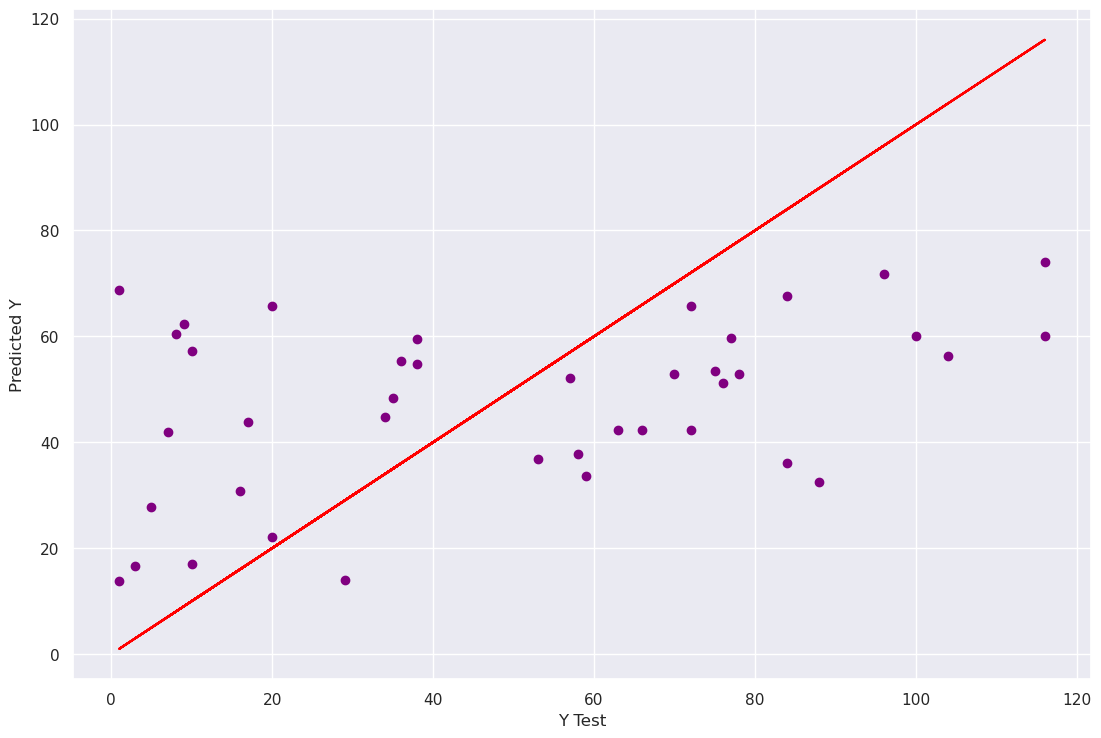

In [87]:
Fitfunction(RidgeRegression)

/tmp/ipykernel_5160/3460672857.py:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_test, hist=True, kde=False, bins=30, color='pink')
/tmp/ipykernel_5160/3460672857.py:9: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(prediction, hist=True, kde=False, bins=30, color='blue')


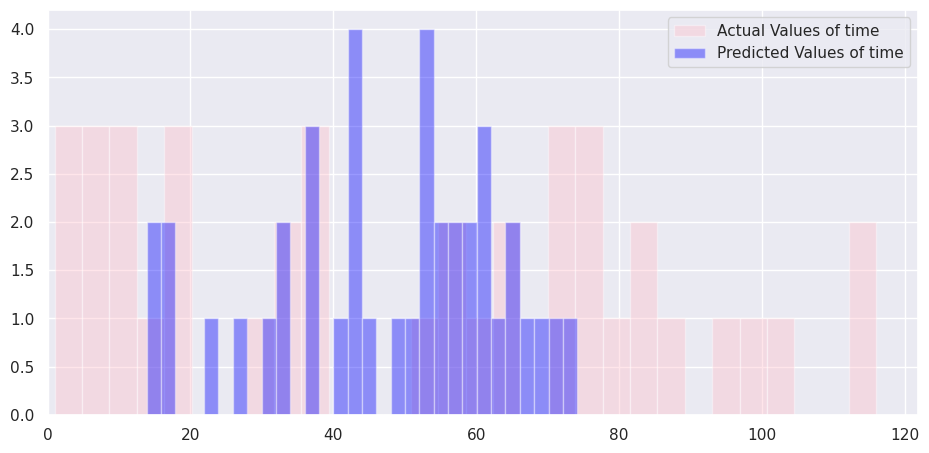

In [88]:
Histo_prediction_true(RidgeRegression)

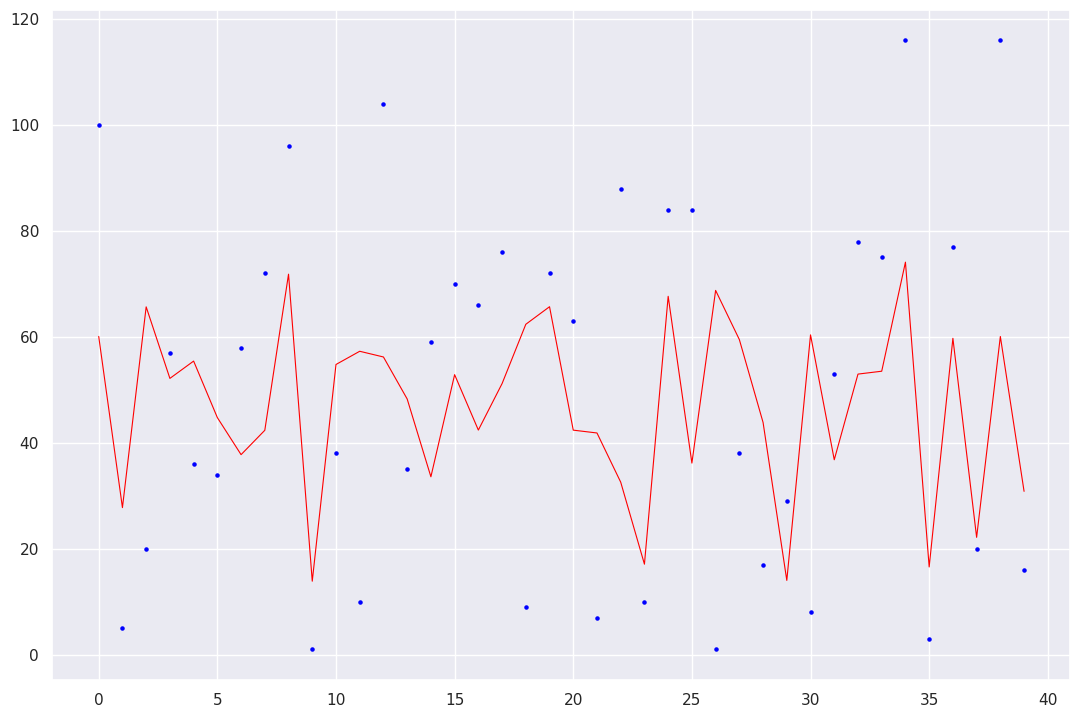

In [89]:
Pred_Real_Model(RidgeRegression)

In [90]:
regression_accuracy(RidgeRegression)

R2 score: 0.16868404252749003
Adjusted R2 score: 0.046431695840356224
__________________________________


# LASSO Regression

 A linear model that estimates sparse coefficients.

 Mathematically, it consists of a linear model trained with $\ell_1$ prior as regularizer. The objective function to minimize is:

$$\min_{w}\frac{1}{2n_{samples}} \big|\big|Xw - y\big|\big|_2^2 + \alpha \big|\big|w\big|\big|_1$$

 The lasso estimate thus solves the minimization of the least-squares penalty with $\alpha \big|\big|w\big|\big|_1$ added, where $\alpha$ is a constant and $\big|\big|w\big|\big|_1$ is the $\ell_1-norm$ of the parameter vector.


In [91]:
from sklearn.linear_model import Lasso

LAssoRgr = Lasso(alpha=0.99, 
              #precompute=True, 
#               warm_start=True, 
              positive=True, 
              selection='random',
              random_state=42)


LAssoRgr.fit(X_Train, y_train)

test_predLR = LAssoRgr.predict(X_Test)
train_predLR = LAssoRgr.predict(X_Train)



results_df_2 = pd.DataFrame(data=[["Lasso Regression", *evaluate(y_test, test_predLR) , cross_val(Lasso())]], 
                            columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square',"Cross Validation"])
results_df = results_df.append(results_df_2, ignore_index=True)



print('Test set evaluation:\n_____________________________________')
print_evaluate(y_test, test_predLR)
print('====================================')
print('Train set evaluation:\n_____________________________________')
print_evaluate(y_train, train_predLR)

Test set evaluation:
_____________________________________
MAE: 30.27947266980314
MSE: 1232.653898063007
RMSE: 35.10917113893473
_ _ _ _ _ _ _ _ _ _  _ _ _ 
R2 Square -0.03170433167601794
_ _ _ _ _ _ _ _ _ _  _ _ _ 
R2 adjusted square -0.18342555692249118
__________________________________
Train set evaluation:
_____________________________________
MAE: 27.374492496547266
MSE: 1080.6825822186574
RMSE: 32.87373696765638
_ _ _ _ _ _ _ _ _ _  _ _ _ 
R2 Square 0.08022248056482673
_ _ _ _ _ _ _ _ _ _  _ _ _ 
R2 adjusted square 0.049966641109722265
__________________________________


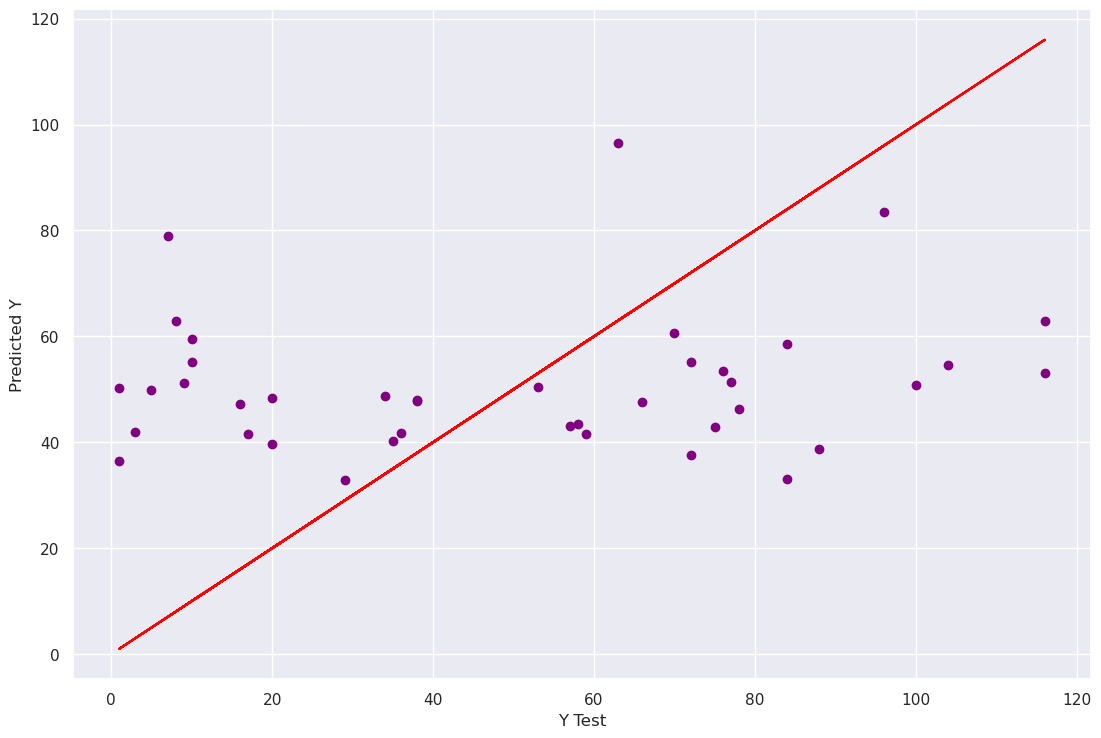

In [92]:
Fitfunction(LAssoRgr)

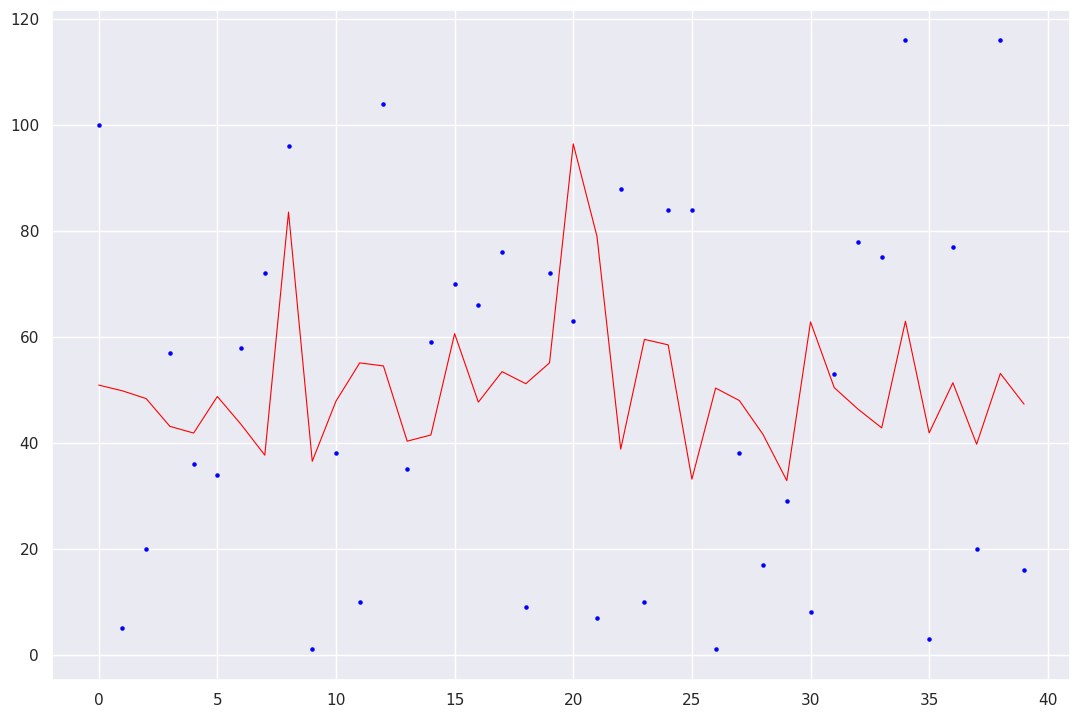

In [93]:
Pred_Real_Model(LAssoRgr)

/tmp/ipykernel_5160/3460672857.py:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_test, hist=True, kde=False, bins=30, color='pink')
/tmp/ipykernel_5160/3460672857.py:9: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(prediction, hist=True, kde=False, bins=30, color='blue')


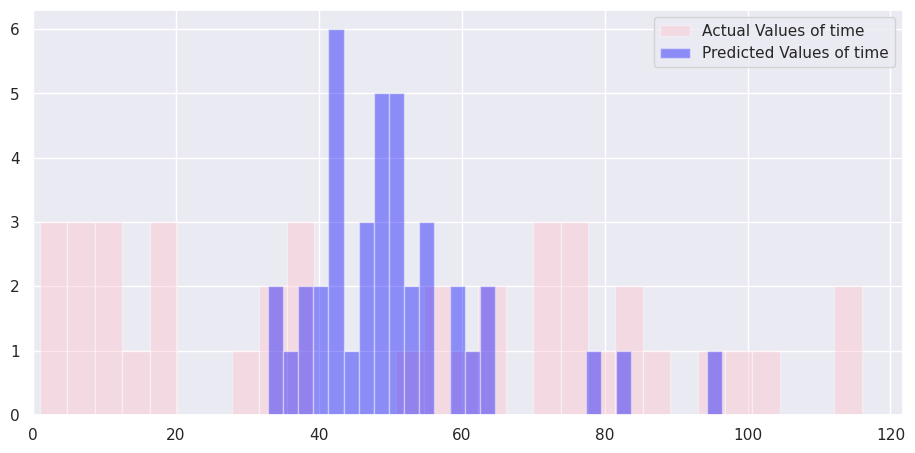

In [94]:
Histo_prediction_true(LAssoRgr)

In [95]:
optimal_alpha(LAssoRgr)

,alpha,error
98,0.99,1232.653898


In [96]:
regression_accuracy(LAssoRgr)

R2 score: -0.03170433167601794
Adjusted R2 score: -0.18342555692249118
__________________________________


#  Elastic Net

 A linear regression model trained with L1 and L2 prior as regularizer. 
This combination allows for learning a sparse model where few of the weights are non-zero like Lasso, while still maintaining the regularization properties of Ridge. 
 Elastic-net is useful when there are multiple features which are correlated with one another. Lasso is likely to pick one of these at random, while elastic-net is likely to pick both.
 A practical advantage of trading-off between Lasso and Ridge is it allows Elastic-Net to inherit some of Ridge’s stability under rotation.
 The objective function to minimize is in this case

$$\min_{w}{\frac{1}{2n_{samples}} \big|\big|X w - y\big|\big|_2 ^ 2 + \alpha \rho \big|\big|w\big|\big|_1 +
\frac{\alpha(1-\rho)}{2} \big|\big|w\big|\big|_2 ^ 2}$$

In [97]:
from sklearn.linear_model import ElasticNet

ElasticNetR = ElasticNet(alpha=0.15, l1_ratio=0.1, selection='random', random_state=42)
ElasticNetR.fit(X_Train, y_train)

test_predER = ElasticNetR.predict(X_Test)
train_predER = ElasticNetR.predict(X_Train)



results_df_2 = pd.DataFrame(data=[["Elastic Net Regression", *evaluate(y_test, test_predER) , cross_val(ElasticNet())]], 
                            columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square', "Cross Validation"])
results_df = results_df.append(results_df_2, ignore_index=True)



print('Test set evaluation:\n_____________________________________')
print_evaluate(y_test, test_predER)
print('====================================')
print('Train set evaluation:\n_____________________________________')
print_evaluate(y_train, train_predER)



Test set evaluation:
_____________________________________
MAE: 27.284850938164983
MSE: 990.0412068894148
RMSE: 31.464920258748705
_ _ _ _ _ _ _ _ _ _  _ _ _ 
R2 Square 0.17135718039699777
_ _ _ _ _ _ _ _ _ _  _ _ _ 
R2 adjusted square 0.04949794222008563
__________________________________
Train set evaluation:
_____________________________________
MAE: 25.22548865696734
MSE: 931.0039817473278
RMSE: 30.5123578529639
_ _ _ _ _ _ _ _ _ _  _ _ _ 
R2 Square 0.20761512491688738
_ _ _ _ _ _ _ _ _ _  _ _ _ 
R2 adjusted square 0.1815498329733639
__________________________________


In [98]:
optimal_alpha(ElasticNetR)

,alpha,error
14,0.15,990.041207


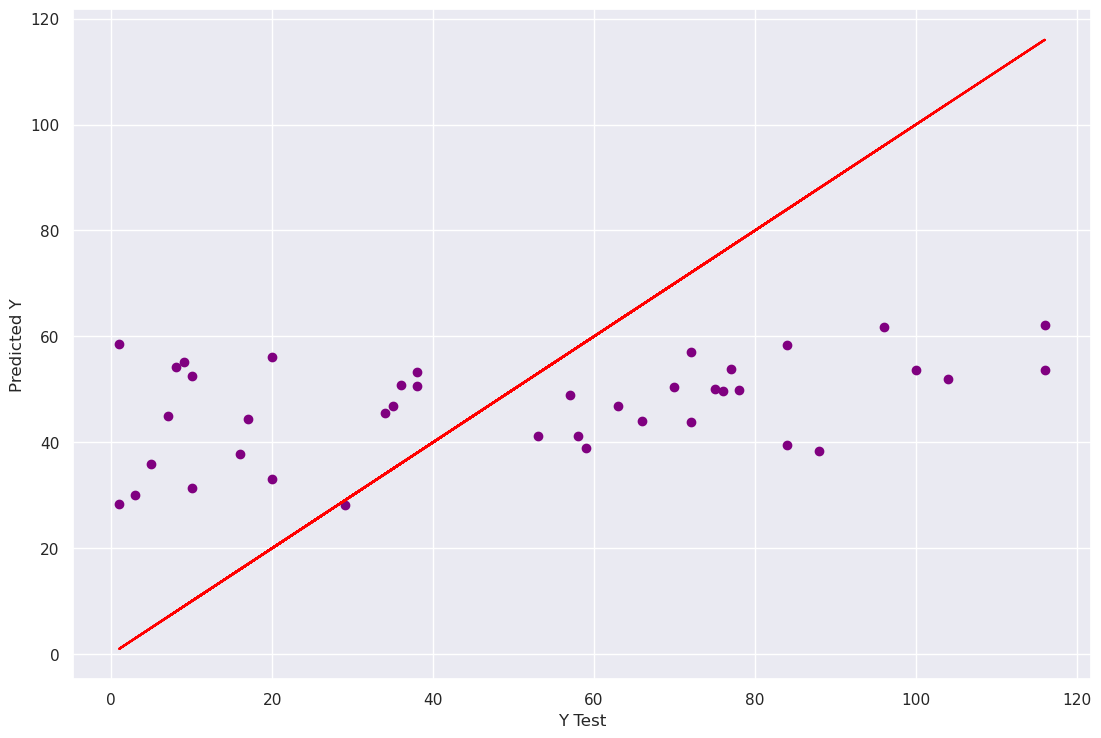

In [99]:
Fitfunction(ElasticNetR)

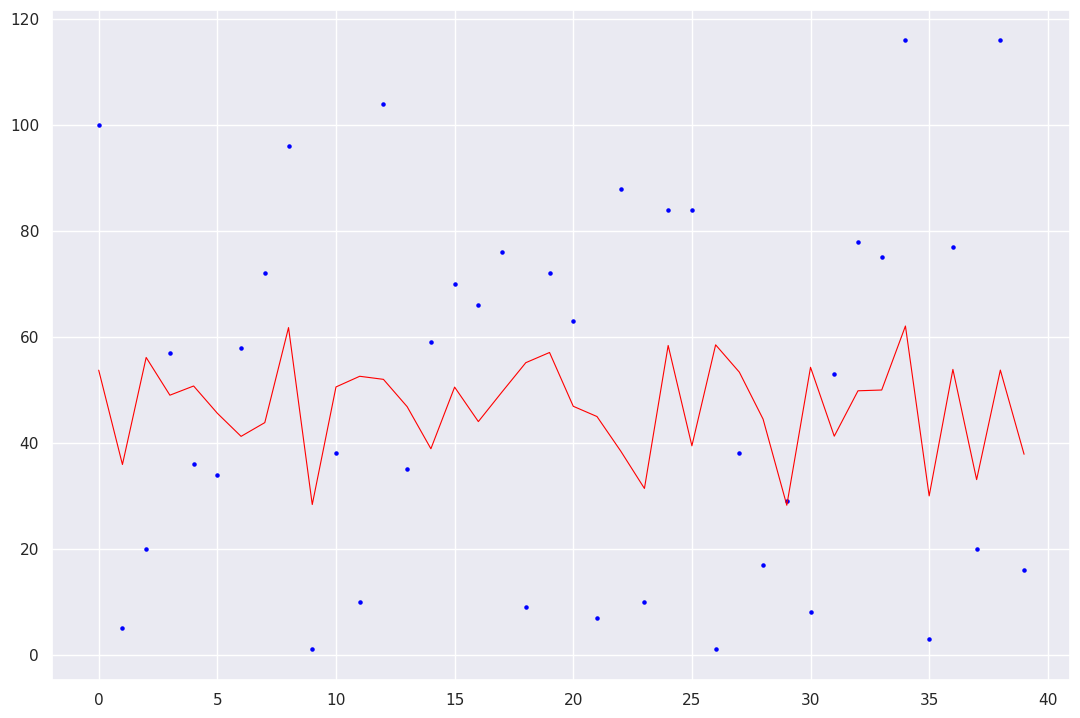

In [100]:
Pred_Real_Model(ElasticNetR)

/tmp/ipykernel_5160/3460672857.py:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_test, hist=True, kde=False, bins=30, color='pink')
/tmp/ipykernel_5160/3460672857.py:9: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(prediction, hist=True, kde=False, bins=30, color='blue')


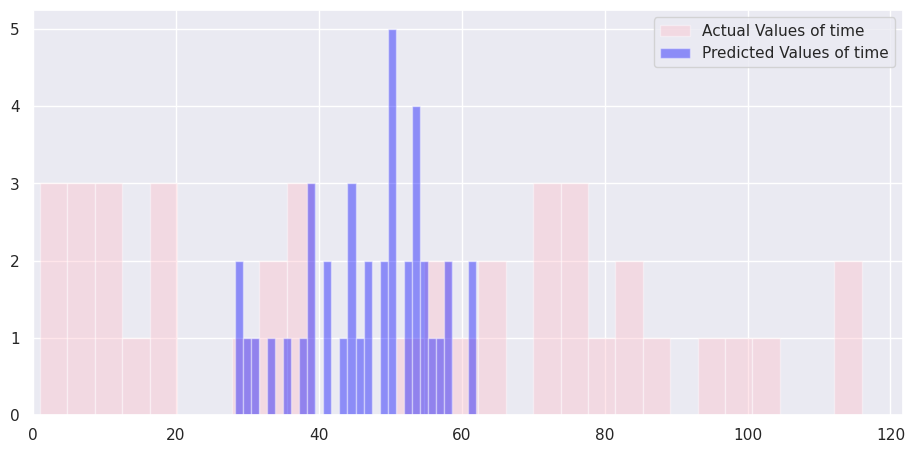

In [101]:
Histo_prediction_true(ElasticNetR)

In [102]:
regression_accuracy(ElasticNetR)

R2 score: 0.14435984773984512
Adjusted R2 score: 0.01853041358394003
__________________________________


In [103]:
#linear regression with gaussian kernel

from sklearn.svm import SVR

SVR_gauss = SVR(kernel='rbf', C=1000, gamma=0.0001)
SVR_gauss.fit(X_Train, y_train)

test_predSVR_gauss = SVR_gauss.predict(X_Test)
train_predSVR_gauss = SVR_gauss.predict(X_Train)


results_df_2 = pd.DataFrame(data=[["Linear Kernel", *evaluate(y_test, test_predSVR_gauss) , cross_val(ElasticNet())]], 
                            columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square', "Cross Validation"])
results_df = results_df.append(results_df_2, ignore_index=True)



print('Test set evaluation:\n_____________________________________')
print_evaluate(y_test, test_predSVR_gauss)
print('====================================')
print('Train set evaluation:\n_____________________________________')
print_evaluate(y_train, train_predSVR_gauss)


Test set evaluation:
_____________________________________
MAE: 28.893425003030767
MSE: 1083.6945906420794
RMSE: 32.91951686525912
_ _ _ _ _ _ _ _ _ _  _ _ _ 
R2 Square 0.09297134813250452
_ _ _ _ _ _ _ _ _ _  _ _ _ 
R2 adjusted square -0.040415218318597956
__________________________________
Train set evaluation:
_____________________________________
MAE: 25.673510438976564
MSE: 997.2401594349553
RMSE: 31.579109541514235
_ _ _ _ _ _ _ _ _ _  _ _ _ 
R2 Square 0.1512409885952688
_ _ _ _ _ _ _ _ _ _  _ _ _ 
R2 adjusted square 0.12332128427274469
__________________________________


In [104]:
#optimize C and gamma

from sklearn.model_selection import GridSearchCV

param_grid = {'C': [0.1, 1, 10, 100, 1000],
                'gamma': [1, 0.1, 0.01, 0.001, 0.0001],

                }

grid = GridSearchCV(SVR(kernel='rbf'), param_grid, refit=True, verbose=3)
grid.fit(X_Train, y_train)


Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV 1/5] END ...................C=0.1, gamma=1;, score=-0.209 total time=   0.0s
[CV 2/5] END ...................C=0.1, gamma=1;, score=-0.040 total time=   0.0s
[CV 3/5] END ...................C=0.1, gamma=1;, score=-0.020 total time=   0.0s
[CV 4/5] END ....................C=0.1, gamma=1;, score=0.003 total time=   0.0s
[CV 5/5] END ...................C=0.1, gamma=1;, score=-0.014 total time=   0.0s
[CV 1/5] END .................C=0.1, gamma=0.1;, score=-0.207 total time=   0.0s
[CV 2/5] END .................C=0.1, gamma=0.1;, score=-0.034 total time=   0.0s
[CV 3/5] END .................C=0.1, gamma=0.1;, score=-0.015 total time=   0.0s
[CV 4/5] END ..................C=0.1, gamma=0.1;, score=0.008 total time=   0.0s
[CV 5/5] END .................C=0.1, gamma=0.1;, score=-0.008 total time=   0.0s
[CV 1/5] END ................C=0.1, gamma=0.01;, score=-0.218 total time=   0.0s
[CV 2/5] END ................C=0.1, gamma=0.01;

GridSearchCV(estimator=SVR(),
             param_grid={'C': [0.1, 1, 10, 100, 1000],
                         'gamma': [1, 0.1, 0.01, 0.001, 0.0001]},
             verbose=3)

In [105]:
regression_accuracy(SVR_gauss)

R2 score: 0.09297134813250452
Adjusted R2 score: -0.040415218318597956
__________________________________


In [106]:
#linear regression with gaussian kernel and l2 regularization

from sklearn.kernel_ridge import KernelRidge

KRR = KernelRidge(alpha=0.15, kernel='polynomial', degree=2, coef0=2.5)
KRR.fit(X_Train, y_train)

test_predKRR = KRR.predict(X_Test)
train_predKRR = KRR.predict(X_Train)



results_df_2 = pd.DataFrame(data=[["Kernel Ridge Regression", *evaluate(y_test, test_predKRR) , cross_val(ElasticNet())]], 
                            columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square', "Cross Validation"])
results_df = results_df.append(results_df_2, ignore_index=True)



print('Test set evaluation:\n_____________________________________')
print_evaluate(y_test, test_predKRR)
print('====================================')
print('Train set evaluation:\n_____________________________________')
print_evaluate(y_train, train_predKRR)



Test set evaluation:
_____________________________________
MAE: 27.53282975014843
MSE: 1074.1858930719761
RMSE: 32.774775255857605
_ _ _ _ _ _ _ _ _ _  _ _ _ 
R2 Square 0.10092991986710775
_ _ _ _ _ _ _ _ _ _  _ _ _ 
R2 adjusted square -0.03128626838772952
__________________________________
Train set evaluation:
_____________________________________
MAE: 23.194972395422575
MSE: 829.2363698887415
RMSE: 28.79646453800781
_ _ _ _ _ _ _ _ _ _  _ _ _ 
R2 Square 0.29423034675377735
_ _ _ _ _ _ _ _ _ _  _ _ _ 
R2 adjusted square 0.271014239739099
__________________________________


In [107]:
optimal_alpha(ElasticNetR)

,alpha,error
14,0.15,990.041207


In [108]:
regression_accuracy(KRR)

R2 score: 0.10092991986710775
Adjusted R2 score: -0.03128626838772952
__________________________________


<AxesSubplot:ylabel='Model'>

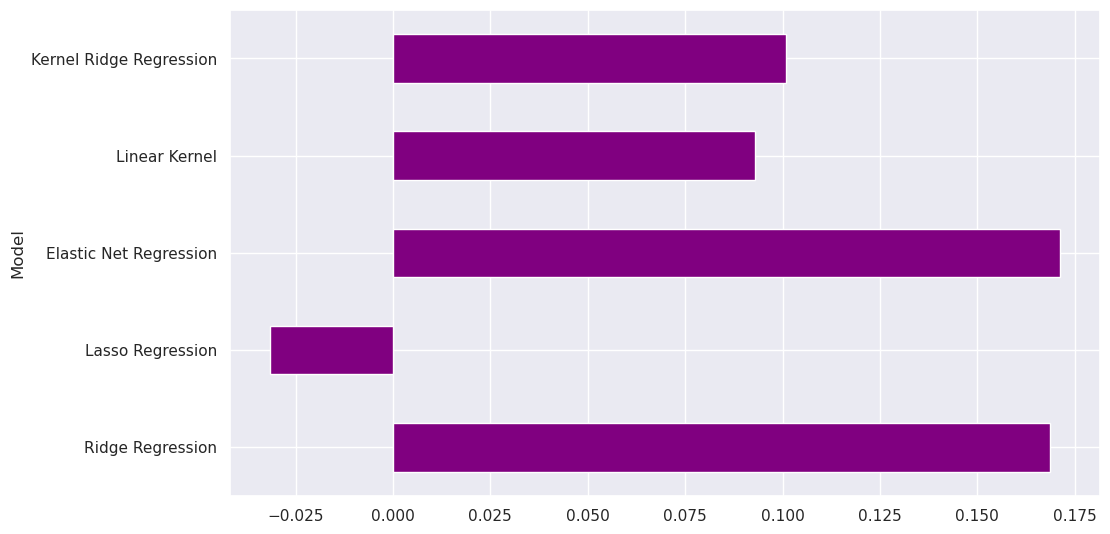

In [109]:

results_df.set_index('Model', inplace=True)
results_df['R2 Square'].plot(kind='barh', color='purple', figsize=(10, 6))


In [110]:
results_df

,MAE,MSE,RMSE,R2 Square,Cross Validation
Model,,,,,
Ridge Regression,26.999274,993.235004,31.515631,0.168684,-5.784576
Lasso Regression,30.279473,1232.653898,35.109171,-0.031704,-5.826419
Elastic Net Regression,27.284851,990.041207,31.464920,0.171357,-5.820542
Linear Kernel,28.893425,1083.694591,32.919517,0.092971,-5.820542
Kernel Ridge Regression,27.532830,1074.185893,32.774775,0.100930,-5.820542


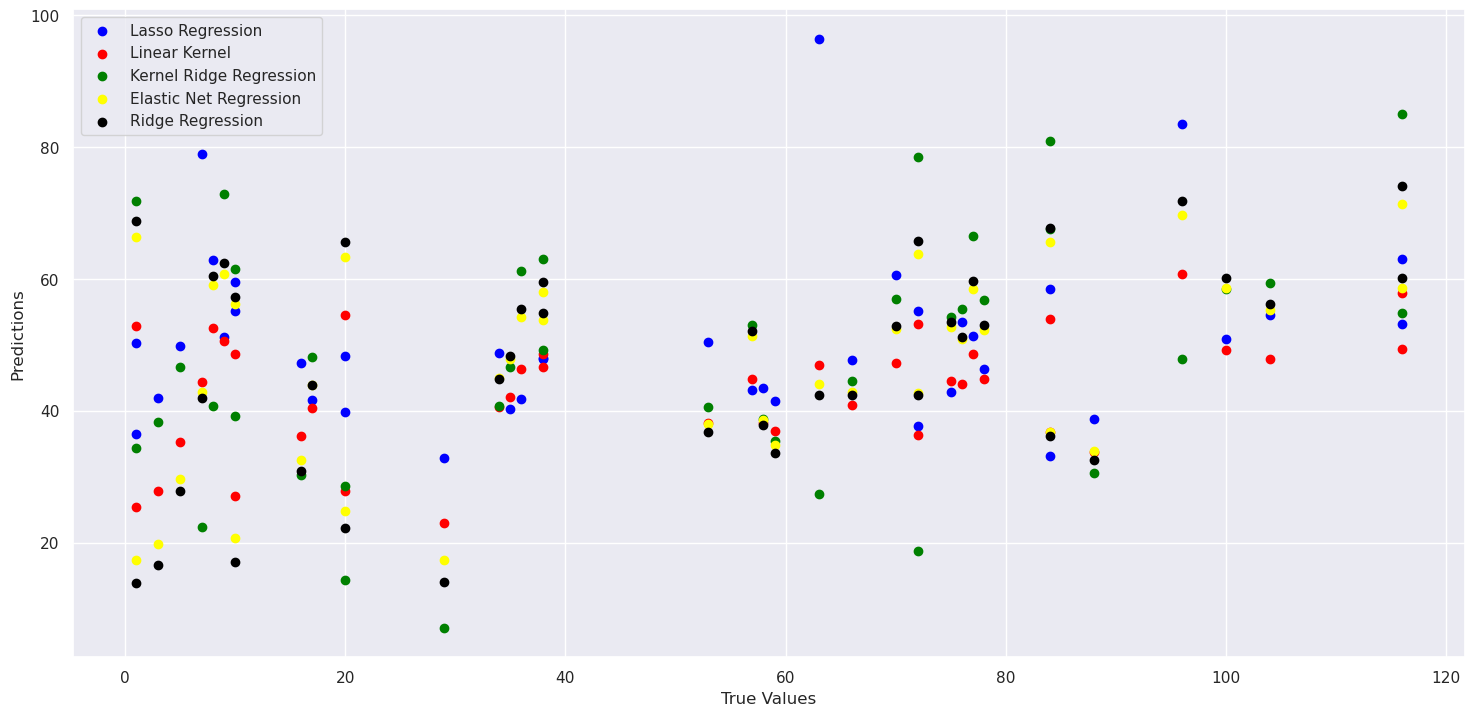

In [111]:
#VIZUALIZATION OF BEST FIT OF ALL MODELS ON THE SAME PLOT

plt.figure(figsize=(16, 8))
plt.scatter(y_test, test_predLR, c='blue', label='Lasso Regression')
plt.scatter(y_test, test_predSVR_gauss, c='red', label='Linear Kernel')
plt.scatter(y_test, test_predKRR, c='green', label='Kernel Ridge Regression')
plt.scatter(y_test, test_predER, c='yellow', label='Elastic Net Regression')
plt.scatter(y_test, test_predRR, c='black', label='Ridge Regression')
plt.legend()
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.show()


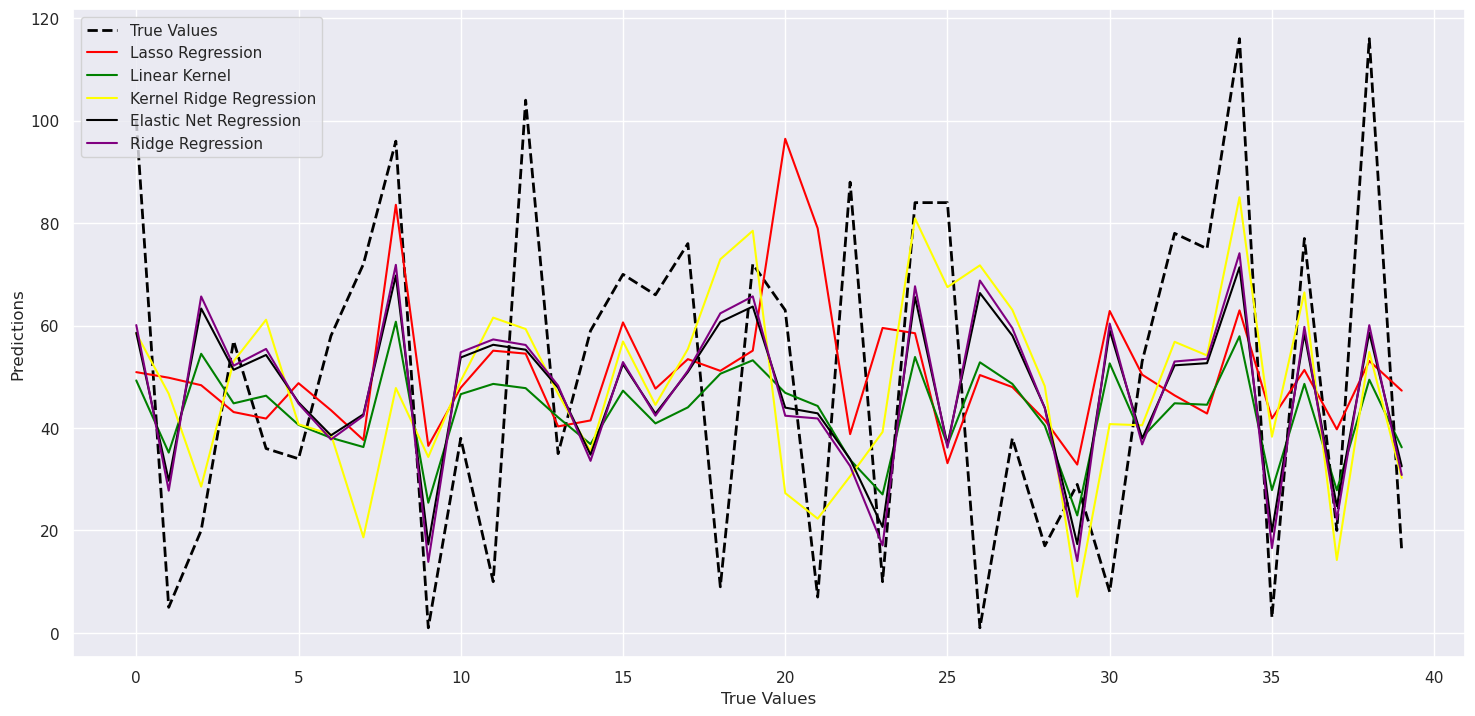

In [112]:
#vizualization real values line plot

plt.figure(figsize=(16, 8))
plt.plot(y_test, c='black', linewidth=2 , linestyle='--', label='True Values')
#change line width

plt.plot(test_predLR, c='red', label='Lasso Regression')
plt.plot(test_predSVR_gauss, c='green', label='Linear Kernel')
plt.plot(test_predKRR, c='yellow', label='Kernel Ridge Regression')
plt.plot(test_predER, c='black', label='Elastic Net Regression')
plt.plot(test_predRR, c='purple', label='Ridge Regression')
plt.legend()
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.show()

